<a href="https://colab.research.google.com/github/StefanoGiacomelli/e2panns/blob/main/E2PANNs_HPs_Search_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

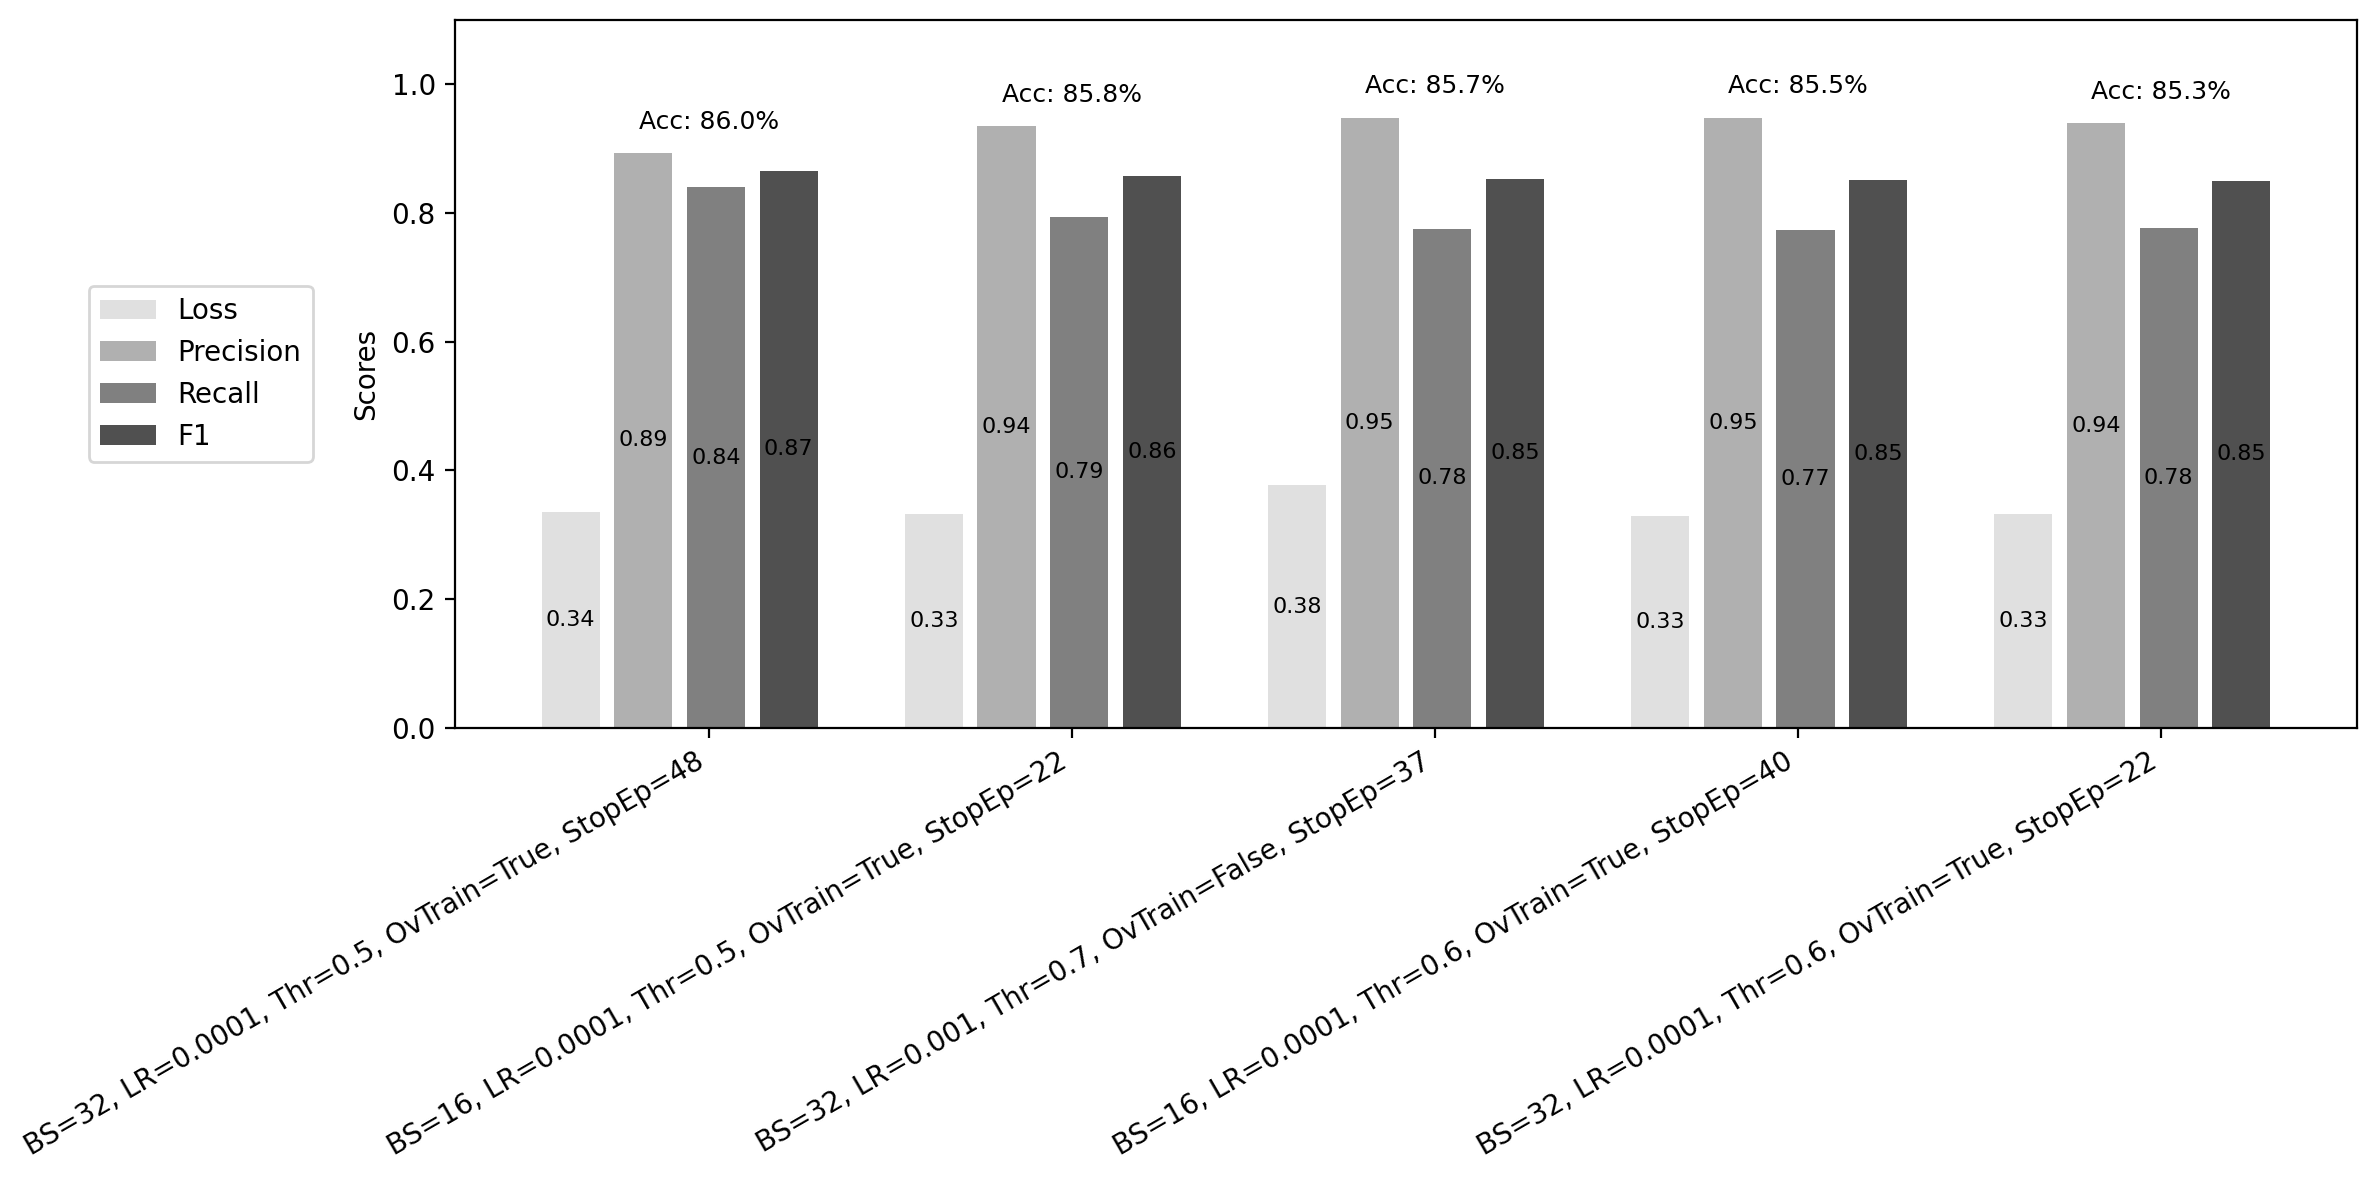

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load your CSV file
df = pd.read_csv("./hp_search_phase1_results.csv")

# Select the top-5 configurations by best_val_acc
top5 = df.sort_values(by="best_val_acc", ascending=False).head(5)

# Define the metrics to plot
metrics = ["best_val_loss", "best_val_prec", "best_val_rec", "best_val_F1"]

# Create formatted hyperparameter labels for the x-axis
labels = []
for _, row in top5.iterrows():
    label = (f"BS={row['batch_size']}, "
             f"LR={row['learning_rate']}, "
             f"Thr={row['threshold']}, "
             f"OvTrain={row['overall_training']}, "
             f"StopEp={row['stop_epoch']}")
    labels.append(label)

# Bar plot parameters
width = 0.2          # width of each bar
intra_gap = 0.05     # gap between bars in the same group
group_gap = 0.3      # gap between different groups

n_groups = len(top5)   # number of groups (configurations)
n_bars = len(metrics)  # number of bars per group

# Compute starting positions for each group
group_positions = [i * (n_bars * (width + intra_gap) - intra_gap + group_gap) for i in range(n_groups)]

# Use distinct grayscale colors for increased contrast
colors = ["#e0e0e0", "#b0b0b0", "#808080", "#505050"]

# Rename metrics in the legend
legend_labels = {"best_val_loss": "Loss",
                 "best_val_prec": "Precision",
                 "best_val_rec": "Recall",
                 "best_val_F1": "F1"}

fig, ax = plt.subplots(figsize=(12, 6))

# Plot each metric as a bar and annotate the value in the center of the bar
for i, metric in enumerate(metrics):
    # Calculate x positions for this metric's bars in each group
    x_positions = [gp + i * (width + intra_gap) for gp in group_positions]
    bars = ax.bar(x_positions,
                  top5[metric],
                  width=width,
                  color=colors[i],
                  label=legend_labels[metric])

    # Annotate each bar with its height value (inside the bar)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2,  # center of the bar
                height / 2,                       # vertical center of the bar
                f"{height:.2f}",
                ha="center", va="center", fontsize=8, color="black")

# Compute the total width of each group for centering the x-axis labels
group_total_width = n_bars * (width + intra_gap) - intra_gap
ax.set_xticks([gp + group_total_width / 2 for gp in group_positions])
ax.set_xticklabels(labels, rotation=30, ha="right")

# Annotate each group with the best_val_accuracy score (in % and in black)
for i, gp in enumerate(group_positions):
    # Group center x coordinate
    x_center = gp + group_total_width / 2
    # Get the best_val_accuracy for this configuration and convert to percentage
    best_acc = top5.iloc[i]["best_val_acc"]
    # Compute the maximum height among the plotted metrics for this group
    row_values = [top5.iloc[i][m] for m in metrics]
    max_height = max(row_values)
    # Position the annotation slightly above the highest bar with a small offset
    y_pos = max_height + 0.03
    ax.text(x_center, y_pos,
            f"Acc: {best_acc * 100:.1f}%",
            ha="center", va="bottom", fontsize=9, color="black",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1))

# Turn off the grid
# ax.grid(False)  # Grid is already off; included explicitly for clarity

# Set y-axis limit to 1.1 to ensure all annotations are inside the plot
ax.set_ylim(0, 1.1)

# Set labels and title
ax.set_ylabel("Scores")
#ax.set_title("Top-5 E2PANNs Set-up by Validation Accuracy (on AudioSet-EV)")

# Place the legend on the left outside of the plot area
ax.legend(loc="center left", bbox_to_anchor=(-0.2, 0.5))

plt.tight_layout()

# Save the plot in high-quality PNG (600dpi)
fig.savefig("E2PANNs_Top5_HP-search.png", dpi=600, bbox_inches='tight')

# Save the plot in SVG format (vector graphic)
fig.savefig("E2PANNs_Top5_HP-search.svg", bbox_inches='tight')

plt.show()

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Read CSV file
data = pd.read_csv('hp_search_results.csv')

# Filter for batch size 32 and sort by threshold then learning_rate
data_bs32 = data[data['batch_size'] == 32].sort_values(by=['threshold', 'learning_rate'])

# Define custom grayscale colorscale: light grey for lower values; dark grey for higher.
grey_colorscale = [[0, "#cccccc"], [1, "#333333"]]

# Create a 2-row subplot layout:
# - Row 1: Two subplots (Precision and Recall)
# - Row 2: One subplot spanning both columns (F1 Score)
# Use zero vertical and horizontal spacing, and minimal margins.
fig = make_subplots(rows=2, cols=2, specs=[[{"type": "scene"}, {"type": "scene"}],
                                           [{"type": "scene", "colspan": 2}, None]],
                    vertical_spacing=0.0,
                    horizontal_spacing=0.0,

                    # Remove subplot titles.
                    subplot_titles=[None, None, None])

# Helper function: add a 3D trace (markers+lines) scaled using the 25th–75th percentiles,
# and mark the best point with a black diamond.
def add_metric_trace(fig, df, metric_col, row, col):
    # Compute 25th and 75th percentiles for independent color scaling.
    vmin = np.percentile(df[metric_col], 25)
    vmax = np.percentile(df[metric_col], 75)

    # Main trace: markers+lines (no colorbar).
    fig.add_trace(go.Scatter3d(x = df['threshold'],
                               y = df['learning_rate'],
                               z = df[metric_col],
                               mode = 'markers+lines',
                               marker = dict(size = 5,
                                             color = df[metric_col],
                                             colorscale = grey_colorscale,
                                             cmin = vmin,
                                             cmax = vmax,
                                             showscale = False),
                               line = dict(color="lightgrey", width=1)),
                  row=row,
                  col=col)

    # Identify the best point (maximum value for this metric).
    best_idx = df[metric_col].idxmax()
    best_point = df.loc[best_idx]
    best_x = best_point['threshold']
    best_y = best_point['learning_rate']
    best_z = best_point[metric_col]

    # Mark the best point with a black diamond.
    fig.add_trace(go.Scatter3d(x=[best_x],
                               y=[best_y],
                               z=[best_z],
                               mode='markers',
                               marker=dict(symbol='diamond',
                                           size=10,
                                           color="black"),
                               showlegend=False),
                  row=row,
                  col=col)

# Add traces for Precision, Recall, and F1 Score (batch size 32).
add_metric_trace(fig, data_bs32, 'best_val_prec', row=1, col=1)
add_metric_trace(fig, data_bs32, 'best_val_rec', row=1, col=2)
add_metric_trace(fig, data_bs32, 'best_val_F1', row=2, col=1)

# Update each 3D scene's axis properties.
# x-axis (Threshold) → [0.49, 0.71],
# y-axis (Learning Rate) → log scale with limits from 1e-5 to 1e-2 (log10 limits: -5 to -2, shown in scientific notation),
# z-axis (Metric) → [0, 1.1].
scene_ids = ["scene", "scene2", "scene3"]
axis_settings = [("Threshold", "Learning Rate", "Precision"),
                 ("Threshold", "Learning Rate", "Recall"),
                 ("Threshold", "Learning Rate", "F1 Score")]

for i, scene_id in enumerate(scene_ids):
    x_title, y_title, z_title = axis_settings[i]
    scene = fig.layout[scene_id]
    scene.xaxis.title.text = x_title
    scene.yaxis.title.text = y_title
    scene.zaxis.title.text = z_title
    scene.xaxis.range = [0.49, 0.71]
    scene.zaxis.range = [0, 1.1]
    scene.yaxis.type = "log"
    scene.yaxis.range = [-5, -2]
    scene.yaxis.tickformat = ".1e"
    scene.xaxis.showgrid = True
    scene.yaxis.showgrid = True
    scene.zaxis.showgrid = True
    scene.xaxis.gridcolor = "gray"
    scene.yaxis.gridcolor = "gray"
    scene.zaxis.gridcolor = "gray"
    scene.xaxis.showbackground = False
    scene.yaxis.showbackground = False
    scene.zaxis.showbackground = False
    scene.bgcolor = "rgba(0,0,0,0)"

# Set default camera view for each scene so that axis ticks are clearly visible.
default_camera = dict(eye=dict(x=1.8, y=1.8, z=1.2))
for scene_id in scene_ids:
    fig.layout[scene_id].camera = default_camera

# Update overall layout: larger overall figure and minimal margins.
fig.update_layout(height=1000,
                  width=1000,
                  margin=dict(l=0, r=0, b=0, t=0))
fig.show()